In [80]:
import subprocess
import sys
import os
import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

# --- 0. INSTALLATION CHECK AND SETUP ---
def install_and_import(package, import_name=None):
    """Checks if a package is installed, and if not, attempts to install it via pip."""
    if import_name is None:
        import_name = package
    try:
        __import__(import_name)
    except ImportError:
        print(f"'{import_name}' not found. Attempting to install '{package}'...")
        try:
            # Install without printing stdout to keep the console clean
            subprocess.check_call([sys.executable, "-m", "pip", "install", package], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            __import__(import_name)
        except subprocess.CalledProcessError as e:
            print(f"Error installing '{package}'. Please run 'pip install {package}' manually.")
            print(f"Details: {e}")
            sys.exit(1)

required_packages = {
    'pandas': 'pandas', 'scikit-learn': 'sklearn', 'ucimlrepo': 'ucimlrepo'
}
for package, import_name in required_packages.items():
    install_and_import(package, import_name)


# Define directories for output
DATA_DIR = 'data_split'
os.makedirs(DATA_DIR, exist_ok=True)

# --- 1. DATA LOADING VIA UCI REPOSITORY (REUSING CLEANED DATASET CONCEPT) ---
print("--- 1. Data Loading via UCI Repository ---")
cardiotocography = fetch_ucirepo(id=193)
X = cardiotocography.data.features
y = cardiotocography.data.targets.copy() # <<< FIX: Explicitly copy targets to prevent SettingWithCopyWarning
y.rename(columns={'NSP': 'Fetal_Status'}, inplace=True)
y = y['Fetal_Status'] # Convert to a Series

# *** FIX FOR XGBOOST/SKLEARN: Transform class labels from 1, 2, 3 to 0, 1, 2 ***
# This is necessary because models expect zero-indexed integer labels.
y = y - 1

print(f"Data successfully loaded. Features shape: {X.shape}, Target shape: {y.shape}")
print("\n--- Sample of Raw Feature Data (X) ---")
print(X.head())

# --- 2. TRAIN/TEST SPLIT (Split into Train and Test) ---
# Stratified Split: Ensures class distribution is maintained across train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print("\nData split successfully (70% Train, 30% Test, Stratified).")

# --- 3. SAVE DATA SPLITS FOR TRAINING AND TESTING ---
X_train.to_csv(f'{DATA_DIR}/X_train.csv', index=False)
X_test.to_csv(f'{DATA_DIR}/X_test.csv', index=False)
# Save y data as DataFrames with the Fetal_Status column name
y_train.rename('Fetal_Status').to_frame().to_csv(f'{DATA_DIR}/y_train.csv', index=False)
y_test.rename('Fetal_Status').to_frame().to_csv(f'{DATA_DIR}/y_test.csv', index=False)

print(f"\nSaved data splits to the '{DATA_DIR}/' directory.")
print("--- Data Preparation Complete. Run train_model.py next. ---")

# Define directories for output
DATA_DIR = 'data_split'
os.makedirs(DATA_DIR, exist_ok=True)

# Save X and y splits as CSV files
X_train.to_csv(f'{DATA_DIR}/X_train.csv', index=False)
X_test.to_csv(f'{DATA_DIR}/X_test.csv', index=False)

# The y Series needs to be converted to a DataFrame with a column name ('Fetal_Status') 
# so it can be loaded back into a DataFrame/Series easily later.
y_train.rename('Fetal_Status').to_frame().to_csv(f'{DATA_DIR}/y_train.csv', index=False)
y_test.rename('Fetal_Status').to_frame().to_csv(f'{DATA_DIR}/y_test.csv', index=False)

print(f"\nSaved X_train, X_test, y_train, and y_test to the '{DATA_DIR}/' directory.")
print("--- Data Preparation Complete. Run your model training script next. ---")


--- 1. Data Loading via UCI Repository ---
Data successfully loaded. Features shape: (2126, 21), Target shape: (2126,)

--- Sample of Raw Feature Data (X) ---
    LB     AC   FM     UC     DL   DS   DP  ASTV  MSTV  ALTV  ...  Width  Min  \
0  120  0.000  0.0  0.000  0.000  0.0  0.0    73   0.5    43  ...     64   62   
1  132  0.006  0.0  0.006  0.003  0.0  0.0    17   2.1     0  ...    130   68   
2  133  0.003  0.0  0.008  0.003  0.0  0.0    16   2.1     0  ...    130   68   
3  134  0.003  0.0  0.008  0.003  0.0  0.0    16   2.4     0  ...    117   53   
4  132  0.007  0.0  0.008  0.000  0.0  0.0    16   2.4     0  ...    117   53   

   Max  Nmax  Nzeros  Mode  Mean  Median  Variance  Tendency  
0  126     2       0   120   137     121        73         1  
1  198     6       1   141   136     140        12         0  
2  198     5       1   141   135     138        13         0  
3  170    11       0   137   134     137        13         1  
4  170     9       0   137   136     13

In [82]:
import subprocess
import sys
import time
import os
import joblib
import pandas as pd
import numpy as np

# --- 0. INSTALLATION CHECK AND SETUP ---
def install_and_import(package, import_name=None):
    """Checks if a package is installed, and if not, attempts to install it via pip."""
    if import_name is None:
        import_name = package
    try:
        __import__(import_name)
    except ImportError:
        print(f"'{import_name}' not found. Attempting to install '{package}'...")
        try:
            # Install without printing stdout to keep the console clean
            subprocess.check_call([sys.executable, "-m", "pip", "install", package], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            print(f"Successfully installed '{package}'.")
            __import__(import_name)
        except subprocess.CalledProcessError as e:
            print(f"Error installing '{package}'. Please run 'pip install {package}' manually.")
            print(f"Details: {e}")
            sys.exit(1)

# List of critical packages (using their pip install name)
required_packages = {
    'pandas': 'pandas', 'scikit-learn': 'sklearn', 'imbalanced-learn': 'imblearn',
    'xgboost': 'xgboost', 'joblib': 'joblib'
}
for package, import_name in required_packages.items():
    install_and_import(package, import_name)

# --- Standard Imports ---
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import recall_score, make_scorer, f1_score, balanced_accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Classifier Imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
import xgboost as xgb


# --- 1. CONFIGURATION AND LOADING DATA ---

DATA_DIR = 'data_split'
MODEL_DIR = 'model_weights'
os.makedirs(MODEL_DIR, exist_ok=True) # Ensure model directory exists

try:
    print("--- 1. Loading Pre-split Data for Training ---")
    # Load data saved by the data preparation script
    # The 'data_split' directory must exist and contain the CSV files.
    X_train = pd.read_csv(f'{DATA_DIR}/X_train.csv')
    y_train = pd.read_csv(f'{DATA_DIR}/y_train.csv')['Fetal_Status'] # Load as Series
    print(f"Loaded training data: {len(X_train)} samples.")
except FileNotFoundError as e:
    print(f"\nFATAL ERROR: Required data file not found: {e.filename}.")
    print("Please ensure you run the data preparation script first to create the 'data_split/' directory and files.")
    sys.exit(1)


# --- 2. MODEL COMPARISON PIPELINES & SCORING (Evaluation Focus) ---

# CRITICAL SCORER: Define a scorer to prioritize RECALL for the Pathologic class (label 2).
def pathologic_recall_scorer(y_true, y_pred):
    """Calculates Recall specifically for the Pathologic class (label 2)."""
    # Calculate Recall only for the Pathologic class (now label 2)
    return recall_score(y_true, y_pred, labels=[2], average='macro', zero_division=0)

pathologic_recall = make_scorer(pathologic_recall_scorer)

# Define Preprocessing steps common to all models: Imputation -> Scaling
preprocessing_steps = [
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
]

# Define all 8 Model Classifiers
models_to_compare = {
    'LogReg': LogisticRegression(multi_class='ovr', solver='liblinear', random_state=42, class_weight='balanced'),
    'DecisionTree': DecisionTreeClassifier(max_depth=7, random_state=42, class_weight='balanced'),
    'RandomForest': RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42, class_weight='balanced'),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42),
    'SVC': SVC(kernel='rbf', gamma='auto', probability=True, random_state=42, class_weight='balanced'),
    'KNeighbors': KNeighborsClassifier(n_neighbors=5),
    'NeuralNet': MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=500, random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, objective='multi:softmax', num_class=3)
}

pipelines = {}
for name, classifier in models_to_compare.items():
    # Use SMOTE within the pipeline for all models
    pipelines[name] = ImbPipeline(steps=preprocessing_steps + [
        ('smote', SMOTE(random_state=42, k_neighbors=3)),
        ('classifier', classifier)
    ])


# --- 3. CROSS-VALIDATION AND SELECTION (Evaluation Focus) ---

print("\n--- 3. Cross-Validating All Models (Scoring: Recall for Pathologic Class) ---")
results_df = pd.DataFrame(columns=['Model', 'Pathologic Recall (CV)', 'F1 Macro (CV)', 'Balanced Accuracy (CV)', 'Time (s)', 'Pipeline'])

for name, pipeline in pipelines.items():
    start_time = time.time()

    # Perform 5-fold cross-validation on the three primary metrics
    cv_pathologic_recall = cross_val_score(pipeline, X_train, y_train, cv=5, scoring=pathologic_recall, n_jobs=-1).mean()
    cv_f1_macro = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1).mean()
    cv_balanced_acc = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='balanced_accuracy', n_jobs=-1).mean()

    end_time = time.time()

    # Store results
    results_df.loc[len(results_df)] = [
        name,
        cv_pathologic_recall,
        cv_f1_macro,
        cv_balanced_acc,
        round(end_time - start_time, 2),
        pipeline
    ]
    print(f"Model: {name} | Path. Recall: {cv_pathologic_recall:.4f} | F1 Macro: {cv_f1_macro:.4f} | Time: {results_df.iloc[-1]['Time (s)']}s")

# Find the Best Model based on Pathologic Recall
best_model_data = results_df.sort_values(by='Pathologic Recall (CV)', ascending=False).iloc[0]
best_model_name = best_model_data['Model']
final_pipeline = best_model_data['Pipeline']

print(f"\n--- BEST MODEL SELECTED (Minimize False Negatives): {best_model_name} (Path. Recall: {best_model_data['Pathologic Recall (CV)']:.4f}) ---")

# Print the comparison table
print("\n--- Comprehensive Model Comparison ---")
print(results_df[['Model', 'Pathologic Recall (CV)', 'F1 Macro (CV)', 'Balanced Accuracy (CV)', 'Time (s)']]\
      .sort_values(by='Pathologic Recall (CV)', ascending=False).to_markdown(index=False))


# --- 4. FINAL TRAINING AND SAVING ---

print("\n--- 4. Training Final Model on Full Training Set ---")
# Train the best pipeline on the full training set (including SMOTE inside the pipeline)
final_pipeline.fit(X_train, y_train)

# Save the final trained pipeline as joblib
MODEL_PATH = f'{MODEL_DIR}/final_best_model.joblib'
joblib.dump(final_pipeline, MODEL_PATH)

print(f"--- Successfully saved final model to: {MODEL_PATH} ---")
print("--- Training Complete. Run test_inference.py next. ---")

--- 1. Loading Pre-split Data for Training ---
Loaded training data: 1488 samples.

--- 3. Cross-Validating All Models (Scoring: Recall for Pathologic Class) ---
Model: LogReg | Path. Recall: 0.8460 | F1 Macro: 0.7664 | Time: 5.18s
Model: DecisionTree | Path. Recall: 0.9267 | F1 Macro: 0.8635 | Time: 0.3s
Model: RandomForest | Path. Recall: 0.9193 | F1 Macro: 0.8959 | Time: 4.4s
Model: GradientBoosting | Path. Recall: 0.9517 | F1 Macro: 0.9099 | Time: 32.47s
Model: SVC | Path. Recall: 0.8467 | F1 Macro: 0.8356 | Time: 7.02s
Model: KNeighbors | Path. Recall: 0.8703 | F1 Macro: 0.8207 | Time: 0.39s
Model: NeuralNet | Path. Recall: 0.8620 | F1 Macro: 0.8480 | Time: 31.9s
Model: XGBoost | Path. Recall: 0.9517 | F1 Macro: 0.9062 | Time: 3.04s

--- BEST MODEL SELECTED (Minimize False Negatives): GradientBoosting (Path. Recall: 0.9517) ---

--- Comprehensive Model Comparison ---
| Model            |   Pathologic Recall (CV) |   F1 Macro (CV) |   Balanced Accuracy (CV) |   Time (s) |
|:-------

--- 1. Loading Test Data and Final Trained Model ---
Loaded test data (638 samples).
Loaded final trained model: GradientBoostingClassifier.

             FINAL MODEL INFERENCE REPORT              
Model Used: GradientBoostingClassifier (Best-Performing Classifier)

| Metric               | Score      | Interpretation                                     |
|----------------------|------------|----------------------------------------------------|
| Pathologic Recall    |   0.9434   | Minimizes missed fetal distress cases (Safety Focus) |
| F1 Macro Score       |   0.8757   | Overall balance between Precision and Recall       |
| Balanced Accuracy    |   0.8917   | Overall performance accounting for class imbalance |

(Metrics are calculated on the 30% hold-out test set.)

--- 4.1 Detailed Classification Report for Final Model (GradientBoostingClassifier) ---
                precision    recall  f1-score   support

    Normal (0)       0.96      0.95      0.96       497
   Suspect (1)    

<Figure size 800x600 with 0 Axes>

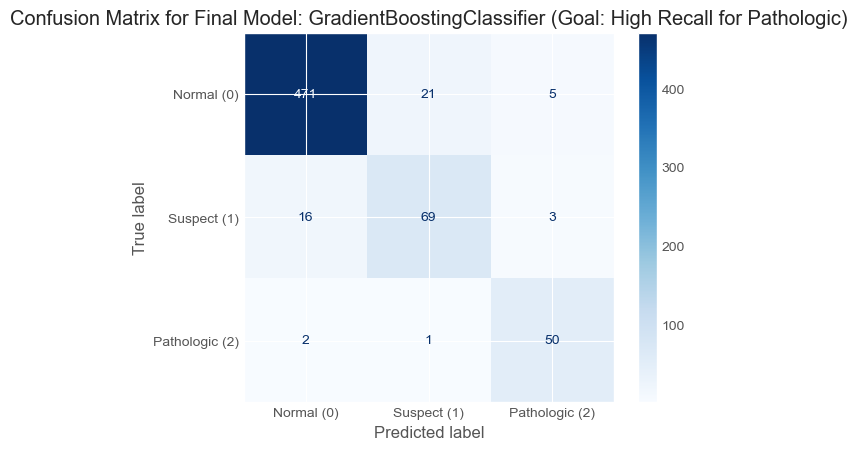


--- 4.3 Feature Importance & Structure for Clinical Understanding (GradientBoostingClassifier) ---


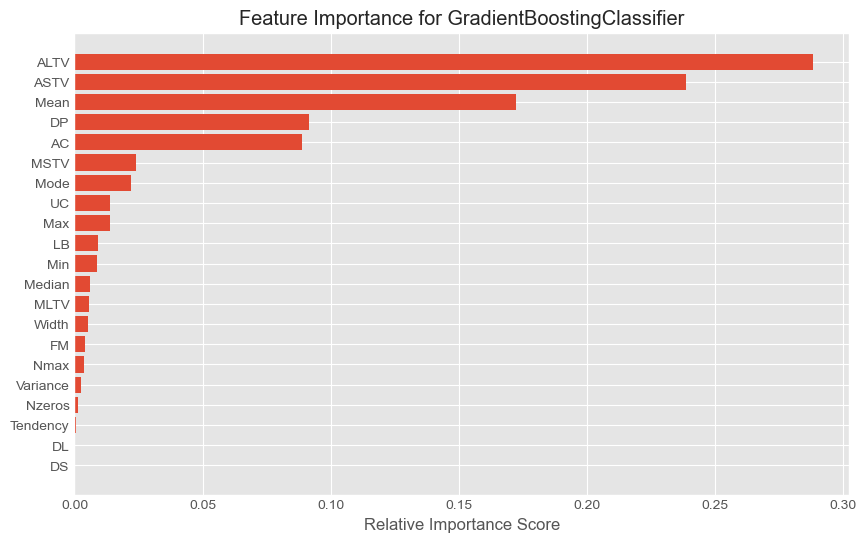


--- Master Datathon Analysis Complete ---


In [84]:
import subprocess
import sys
import os
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, f1_score, balanced_accuracy_score
from sklearn.tree import plot_tree # Import for visualizing the tree structure

# --- 0. INSTALLATION CHECK AND SETUP ---
def install_and_import(package, import_name=None):
    """Checks if a package is installed, and if not, attempts to install it via pip."""
    if import_name is None:
        import_name = package
    try:
        __import__(import_name)
    except ImportError:
        print(f"'{import_name}' not found. Attempting to install '{package}'...")
        try:
            # Install without printing stdout to keep the console clean
            subprocess.check_call([sys.executable, "-m", "pip", "install", package], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
            print(f"Successfully installed '{package}'.")
            __import__(import_name)
        except subprocess.CalledProcessError as e:
            print(f"Error installing '{package}'. Please run 'pip install {package}' manually.")
            print(f"Details: {e}")
            sys.exit(1)

# List of critical packages (using their pip install name)
required_packages = {
    'pandas': 'pandas', 'scikit-learn': 'sklearn', 'matplotlib': 'matplotlib',
    'xgboost': 'xgboost', 'imbalanced-learn': 'imblearn' # imblearn needed for ImbPipeline loading
}
for package, import_name in required_packages.items():
    install_and_import(package, import_name)


# Set consistent styling for plots
plt.style.use('ggplot')

# --- 1. CONFIGURATION AND LOADING ARTIFACTS ---

DATA_DIR = 'data_split'
MODEL_DIR = 'model_weights'
MODEL_PATH = f'{MODEL_DIR}/final_best_model.joblib'

try:
    print("--- 1. Loading Test Data and Final Trained Model ---")
    # Load test data saved by data_exploration/data_prep.py
    X_test = pd.read_csv(f'{DATA_DIR}/X_test.csv')
    y_test = pd.read_csv(f'{DATA_DIR}/y_test.csv')['Fetal_Status'] # Load as Series

    # Load the best trained pipeline (saved by train_model.py)
    final_pipeline = joblib.load(MODEL_PATH)
    best_model_name = final_pipeline.named_steps['classifier'].__class__.__name__

    # Map the technical class name back to the project name if possible
    if 'GradientBoostingClassifier' in best_model_name:
        best_model_display_name = 'GradientBoostingClassifier'
    elif 'XGBClassifier' in best_model_name:
        best_model_display_name = 'XGBoostClassifier'
    else:
        best_model_display_name = best_model_name
        
    print(f"Loaded test data ({len(X_test)} samples).")
    print(f"Loaded final trained model: {best_model_display_name}.")

except FileNotFoundError as e:
    print(f"\nFATAL ERROR: Required file not found: {e.filename}.")
    print("Please ensure you have run data_prep.py AND train_model.py successfully to create all required files.")
    sys.exit(1)


# --- 2. FINAL PREDICTION AND METRIC CALCULATION ---

# Predict on the hold-out test set
y_pred = final_pipeline.predict(X_test)

# Define target names (Labels are 0, 1, 2)
target_names = ['Normal (0)', 'Suspect (1)', 'Pathologic (2)']

# 2.1 Calculate Final Metrics (using the same scorers as the master script)
# Note: Pathologic label is 2
final_pathologic_recall = recall_score(y_test, y_pred, labels=[2], average='macro', zero_division=0)
final_f1_macro = f1_score(y_test, y_pred, average='macro', zero_division=0)
final_balanced_acc = balanced_accuracy_score(y_test, y_pred)


# --- 3. FINAL MODEL INFERENCE REPORT (CONSOLE OUTPUT) ---

metrics_data = [
    ("Pathologic Recall", final_pathologic_recall, "Minimizes missed fetal distress cases (Safety Focus)"),
    ("F1 Macro Score", final_f1_macro, "Overall balance between Precision and Recall"),
    ("Balanced Accuracy", final_balanced_acc, "Overall performance accounting for class imbalance")
]

print("\n" + "=" * 55)
print("{:^55}".format("FINAL MODEL INFERENCE REPORT"))
print("=" * 55)
print(f"Model Used: {best_model_display_name} (Best-Performing Classifier)\n")

# Print the fixed-width console output table
print("| {:<20} | {:<10} | {:<50} |".format("Metric", "Score", "Interpretation"))
print("|{:-<22}|{:-<12}|{:-<52}|".format("", "", "")) # Separator line with exact column widths

for metric_name, score, interpretation in metrics_data:
    # Use f-string for formatting with fixed widths and 4 decimal places
    print(f"| {metric_name:<20} | {score:^10.4f} | {interpretation:<50} |")

print("\n(Metrics are calculated on the 30% hold-out test set.)")


# --- 4. VISUALIZATION AND INTERPRETATION ---

# 4.1 Classification Report (Detailed Breakdown)
print(f"\n--- 4.1 Detailed Classification Report for Final Model ({best_model_display_name}) ---")
print(classification_report(y_test, y_pred, target_names=target_names))


# 4.2 Confusion Matrix Visualization
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title(f'Confusion Matrix for Final Model: {best_model_display_name} (Goal: High Recall for Pathologic)')
plt.show(block=False) # Show plot non-blocking


# 4.3 Feature Importance & Tree Visualization (Only for Tree-based models)
classifier_step = final_pipeline.named_steps['classifier']
is_tree_model = hasattr(classifier_step, 'feature_importances_')

if is_tree_model:
    print(f"\n--- 4.3 Feature Importance & Structure for Clinical Understanding ({best_model_display_name}) ---")

    # Access the trained classifier step inside the pipeline
    model = classifier_step
    importances = model.feature_importances_
    # Use original feature names from the test set
    feature_names = X_test.columns
    sorted_indices = np.argsort(importances)

    # --- A. Feature Importance Plot ---
    plt.figure(figsize=(10, 6))
    plt.title(f"Feature Importance for {best_model_display_name}")
    plt.barh(range(X_test.shape[1]), importances[sorted_indices], align='center')
    plt.yticks(range(X_test.shape[1]), feature_names[sorted_indices])
    plt.xlabel("Relative Importance Score")
    plt.show(block=False)

    # --- B. Decision Tree Structure Visualization (for DecisionTree only) ---
    if 'DecisionTreeClassifier' in best_model_name:
        print("\n--- Decision Tree Structure Visualization (Max Depth 3) ---")
        tree_model = classifier_step
        plt.figure(figsize=(18, 10))
        # Plot the first few decision nodes (max_depth=3) for clarity
        plot_tree(tree_model,
                  feature_names=feature_names,
                  class_names=target_names,
                  filled=True,
                  rounded=True,
                  fontsize=8,
                  max_depth=3)
        plt.title(f'Decision Tree Visualization (First 3 Levels) - {best_model_display_name}')
        plt.show(block=True)
    else:
        # Show Feature Importance plot last if the winner is not a single Decision Tree
        plt.show(block=True)

else:
    print(f"\nFeature Importance Plot skipped: Not applicable for selected model ({best_model_display_name}).")

print("\n--- Master Datathon Analysis Complete ---")